# Solución Tarea
Espacio para desarrollar la tarea propuesta sobre la fase de entendimiento de datos

### Perfilamiento de datos

## Introducción
    
    Al desarrollar esta tarea, se busca comprender la fase de entendimiento de datos de la metodología ASUM-DM para la empresa WWImporters, para esto, se realizará un perfilamiento general, análisis de reglas de negocio, estadísticos y análisis de calidad de datos.
    
    La fase de entendimiento de datos es fundamental ya que nos permite familiarizarnos con los datos de la organización, sus relaciones, determinar en primera medida la viabilidad de realizar un proyecto de analítica dada la información suministrada, determinar si los datos son suficientes y las acciones de mejora que se pueden realizar para obtener resultados confiables, además, nos permite identificar nuevas oportunidades de analítica.

### Configuración e importe de paquetes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
db_user = 'Estudiante_81_202413'
db_psswd = 'aabb1122'

PATH='./'

### Perfilamiento de datos
Esta primera sección de perfilamiento de datos se centrará en tres aspectos fundamentales que son  **entendimiento general** que hace referencia a tener una comprensiòn global antes de entrar en los detalles de los datos compartidos, validación de **reglas de negocio** que corresponden a especificaciones dadas por el negocio en relación con los datos y **análisis descriptivo** en donde se revisan estadísticas como mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos y diagramas para la visualización de los datos. El **análisis de calidad** se abordará en una sección posterior.

### Información dada por la organización relacionada con los datos

Para este estudio y entendimiento de datos, el enfoque estará sobre el análisis de los datos de movimientos de inventarios, la información será tomada de la tabla movimientosCopia que registra el movimiento en inventario de un producto. Un movimiento se refiere a cualquier caso, ya sea ingreso (cantidades positivas) o retiro (cantidades negativas), la cantidad máxima se refiere a que la cantidad del movimiento en valor absoluto no supere los 50 millones

En relación a los datos Wide World Importers menciona:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación se define una función que permite establecer la conexión a la base de datos, para el esquema WWImportersTransactional con el fin de analizar la información contenida especialmente en la tabla **movimientosCopia**

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se va a acceder directamente a la tabla dado su nombre WWImportersTransactional.movimientosCopia

In [6]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [7]:
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Entendimiento general de datos

Se mostrarán las primeras 10 filas que están presentes en la tabla movimientosCopia para ver la información y estructura.

In [8]:
movimientos.show(10)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Según la información que se presenta en la tabla, se puede observar que en los movimientos tenemos información relacionada al **producto**, **clientes**, **facturas**, **proveedores** y a los **movimientos**. Se puede observar que el producto se puede obtener a partir del ProductoID, el cliente se puede obtener a través del atributo ClienteID,  la factura está identificada por el atributo InvoiceID, el proveedor se puede obtener a partir del ProveedorID, la orden de compra relacionada al movimiento se obtiene del atributo OrdenDeCompraID y los atributos que permiten ver obtener la información específica del movimiento son la FechaTransaccion que corresponde a la fecha en que se dio el movimiento en el inventario, la Cantidad que corresponde a la cantidad de productos que se retiraron o ingresaron al inventario, el TransaccionProductoID es la llave primaria de la tabla, que en teoría debería identificar de manera única a cada movimiento.

In [9]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Con la ejecución del esquema para la tabla movimientosCopia se puede observar que hay tipos de datos que no corresponden, por ejemplo, el identificador OrdenDeCompraID es de tipo cadena, esto no se corresponde con el atributo ID_de_pedido de la tabla ordenesCopia, que según el diccionario de datos es la llave primaria de la tabla y que en la tabla está definido de tipo int, también resulta extraño que ProveedorID esté definido como tipo cadena ya que muestra números como si fueran doubles y que ClienteID e InvoiceID estén como tipos double, por lo general, los identificadores primarios que son numéricos se definen como int.

**¿Qué es una fila de la fuente compartida?**
Con los análisis antes mencionados, se puede concluir que una fila de la tabla movimientosCopia es la cantidad en la que se ha extraido o agregado un producto del inventario en una fecha determinada.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [10]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204.292 movimientos y tenemos en total 9 variables a revisar asociadas a los movimientos de las cuales 6 son nùmericas y 3 son de tipo cadena de caracteres, cabe mencionar que la variable FechaTransaccion no se toma como tipo fecha ya que esta está definida como tipo cadena.

### Revisión de reglas de negocio 
Se confirmarán las reglas de negocio que se han suministrado, como primera medida, Wide World Importers menciona que la cantidad máxima de productos movidos es 50 millones por transacción, vemos que esta regla no se cumple dado que al agrupar por la columna TipoTransaccionID y contar el número de productos movidos por transacción, aparece que el tipo de transacción con id 11 posee 154.702.496 productos movidos, esto supera en más del triple a lo 50 millones que Wide World Importers mencionó, por lo que es necesario pedir aclaraciones al negocio en relación a este descubrimiento.

In [11]:
movimientos.groupBy("TipoTransaccionID").sum("Cantidad").show()

+-----------------+-------------+
|TipoTransaccionID|sum(Cantidad)|
+-----------------+-------------+
|               12|        -24.0|
|               10|   -7714426.0|
|               11| 1.54702496E8|
+-----------------+-------------+



Al examinar la segunda regla de negocio mencionada, se especifica que existen 236.668 movimientos de producto realizados desde 2013, como primera instancia, 
se procede a evaluar si existen registros cuya fecha sea inferior al año 2013.

In [12]:
movimientos.agg({"FechaTransaccion": "min"}).show()

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+



In [13]:
regex = "[1-2][0-9][0-9][0-2]"
movimientos.filter(movimientos["FechaTransaccion"].rlike(regex)).count()

0

Se puede observar que en la columna FechaTransaccion no existen fechas con año inferior a 2013, por lo que se asume que todos los movimientos almacenados son iguales o superiores al años 2013, de esta manera, se consultará el total de movimientos registrados.

In [14]:
movimientos.count()

204292

Se puede observar que la totalidad de movimientos no logra alcanzar la totalidad de movimientos que el negocio menciona ya que la totalidad de movimientos es 204.292. Los registros faltantes son 32.376.
La situación de datos faltantes podría aún ser peor, ya que pueden existir registros duplicados y si existen hay que reportarlos y eliminarlos en la fase de preparación de los datos. Esta es la primera **conclusión** del análisis de entendimiento de datos.

In [15]:
movimientos.distinct().count() 

173659

Como se puede apreciar, existen 173.659 movimientos únicos, es decir que hay 30.633 movimientos repetidos, por lo que en la base de datos en realidad tendríamos 173.659 movimientos únicos, de esta manera, se puede concluir que faltan 63.009 registros. Esta información debe ser reportada a negocio.

La siguiente regla de negocio a analizar es que los movimientos están relacionados con 228.265 clientes, se ejecutará la siguiente consulta con el fin de determinar cuántos clientes estuvieron relacionados con los movimientos.

In [16]:
movimientos.select(col('ClienteID')).distinct().count()

664

Esto se debe a que un cliente puete estar relacionado en varios movimientos, como se puede apreciar en la siguiente consulta

In [17]:
movimientos.groupby("ClienteID").count().show()

+---------+-----+
|ClienteID|count|
+---------+-----+
|    596.0|  315|
|    496.0|  316|
|    934.0|  307|
|    558.0|  385|
|   1051.0|   88|
|    170.0|  338|
|    184.0|  315|
|    810.0|  401|
|    147.0|  277|
|    576.0|  275|
|    160.0|  236|
|    169.0|  333|
|    994.0|  306|
|    486.0|  277|
|     70.0|  376|
|    571.0|  289|
|     67.0|  358|
|      8.0|  234|
|    878.0|  280|
|    818.0|  253|
+---------+-----+
only showing top 20 rows



Algo que se puede evidenciar de la consulta anterior, es que ClientID es de tipo double, algo que no suele ser común en llaves primarias de una tabla. Ante el gran desfase de información referente a los clientes relacionados con los movimientos, se puede concluir que faltan más de 227.601 clientes para estar relacionados con los movimientos y esto se le debe comunicar al negocio ya que esta falta podría generar gran incertidumbre en el análisis de información.

La siguiente regla de negocio a evaluar es que el formato de fechas manejado es YYYY-MM-DD HH:MM:SS, para verificar la correctitud de la regla, en la tabla movimientosCopia existe el campo FechaTransaccion, este campo es de tipo cadena, por lo que podría estar aceptando fechas en diversos formatos, es más, sin las validaciones pertinentes podría estar aceptando cualquier cadena, por esto se hará uso de una expresión regular que permita obtener las fechas en el formato brindado por el negocio

In [18]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato correcto: "+str(cumplenFormato.count()))

Número total de movimientos: 204292, número de movimientos con formato correcto: 140038


Podemos ver cómo están viniendo aquellos registros con formato inválido

In [19]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
|     Sep 15,2014|
|     Aug 04,2015|
|     Feb 23,2015|
|     May 01,2015|
|     Jan 08,2016|
|     Mar 26,2014|
|     Jul 31,2015|
|     Sep 02,2014|
|     Mar 15,2016|
|     May 28,2016|
|     Sep 09,2015|
|     May 23,2014|
|     Aug 20,2014|
|     Jan 21,2015|
|     Dec 29,2015|
+----------------+
only showing top 20 rows



(64254, None)

Esto nos da a entender que 64.254 registros no cumplen con el formato indicado por el negocio, sin embargo, esto tal vez no requiera de una aclaración por parte de negocio si no más bien podría ser notificado al negocio para que sea de su conocimiento.

La última regla de negocio es "Actualmente tenemos 13 proveedores", como la empresa no compartió información de las tablas de clientes ni proveedores, se procede a exáminar cuántos proveedores existen relacionados con los movimientos.

In [20]:
movimientos.select(col('ProveedorID')).distinct().count()

4

Se puede apreciar que desde la información proporcionada por la empresa, existen 4 proveedores, lo cuál muestra una diferencia considerable de 9 proveedores que aún no tienen relación con los movimientos, es importante pedir una aclaranción al negocio con respecto a este descubrimiento.

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, se realizará el perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()ordenes.summary().show()

In [21]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

En el conteo vemos que ninguna columna da como resultado 0, por el contrario, todas dan como resultado 204.292, esto resulta interesante, ya que todas las columnas podrían contener valores nulos, sin embargo, acá se evidencia que todas las filas tienen asignado un valor a cada columna. También se puede apreciar que para los identificadores y claves foráneas se calcula la media, sin embargo, esta información carece de sentido para estos campos, por otra parte, se puede evidenciar que para la columna Cantidad se pueden estar ingresando o extrayendo 719.49 productos en promedio, también se puede evidenciar que para las columnas ClienteID e InvoiceID el identificador mínimo es 0.0, esto puede deberse a que posiblemente no se están asociando un cliente o factura al movimiento y se opta por poner 0.0, además, se hace evidente que son valores doubles, por otra parte, acá se resalta más la idea de que no existen fechas de transacciones por debajo del año 2013, ya que la fecha mínima se muestra del 2013-12-31. Por último, el 75% de los datos para Cantidad no superan el -5.0, esto puede dar a entender que muchos de los movimientos se dan por extracciones. 

A continuación se mostrará un diagrama de caja con el fin de detectar valores atípicos en la columna Cantidad

{'whiskers': [<matplotlib.lines.Line2D at 0x248cc51b488>,
 'caps': [<matplotlib.lines.Line2D at 0x248cc316608>,
 'boxes': [<matplotlib.lines.Line2D at 0x248ccc320c8>],
 'medians': [<matplotlib.lines.Line2D at 0x248d124a0c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x248d124ac48>],
 'means': []}

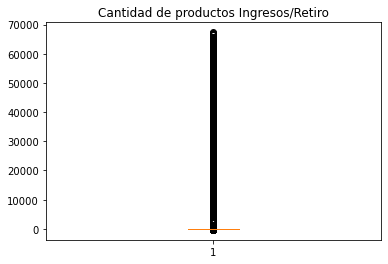

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos Ingresos/Retiro')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

Lastimosamente en el diagrama de caja, dada la gran dispersión que existe entre valores de cantidad negativos(retiro) y positivos(ingresos), no se evidencia muy bien los valores, sin embargo, acá se logra apreciar lo que anteriormente se mencionó, el 75% de los datos muestra movientos con cantidad de hasta -5

In [23]:
movimientos.select(col('Cantidad')).where(col('Cantidad')<=-5).count()

153728

Acá se puede apreciar que más de 153 mil movimientos se debena a retiros de hasta 5 productos, lo cual equivale al 75%.

### Análisis de calidad de datos

Para evaluar la calidad de los datos, se determinará la idoneidad de la dimensión de completitud, unicidad, consistencia y validez.

#### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio que menciona "Existen 236.668 movimientos de producto realizados desde 2013" en donde se encontraron movimientos duplicados y la validez se revisó en la regla de negocio 4 que menciona "El formato de fechas manejado es YYYY-MM-DD HH:MM:SS" en donde se envidenció existen fechas para la columna FechaTransaccion que no cumplen con el formato indicado.

#### Completitud y validez
El código tomado a continuación es adaptado del tutorial y me pareció valiosa la implementación para evaluar la completitud y validez de la información ya que los métodos se adaptan a el dataframe que se pasa por parámetro sin tener que modificar los métodos.

In [24]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [25]:
contar_vacios(movimientos)

[]

Como se ve en el resultado, a pesar de que todas las columnas en la tabla movimientosCopia pueden almacenar valores nulos, no hay ninguna columna que tenga como valor un null, pero esto no es precisamente algo bueno ya que si en la columna ProveedorID si bien no hay nulos, hay campos con cadenas vacías

In [26]:
movimientos.filter(movimientos.ProveedorID=='').count()

197182

Como se puede observar, más de 197 mil movimientos tienen proveedores con un string vacío, por lo que esta columna no tiene más del 90% de información, el mismo resultado también se puede ver reflejado en la columan OrdenDeCompraID.

In [27]:
movimientos.filter(movimientos.OrdenDeCompraID=='').count()

197182

In [28]:
cardinalidad(movimientos)

{'TransaccionProductoID': 173659}

Solo la columna TransaccionProductoID tiene una cardinalidad superior al 50% con respecto del total de movimientos

#### Consistencia
Para determinar la consistencia de la tabla, se procede a evaluar la columna cantidad, dado que los movimientos tienen sentido si se agrega o retira un producto, se procede a evaluar si la cantidad de productos retirados o agregados es cero

In [29]:
movimientos.select(col('*')).where(col('Cantidad')==0).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|                97776|        81|               12|      0.0|      0.0|           |               |2014-01-31 14:00:...|     0.0|
|                97778|        75|               12|      0.0|      0.0|           |               |2014-01-31 14:00:...|     0.0|
|               194927|       150|               12|      0.0|      0.0|           |               |2015-01-31 14:00:...|     0.0|
|               221188|        34|               12|      0.0|      0.0|           |               |2015-04-30 14:00:...|     0.0|
|                97778|        75|               12|      0.0|      0.0|           

Se puede observar que existen 5 filas cuya cantidad es 0, esto es extraño ya que se interpretaría como si no se hubiese hecho movimiento, por lo que resulta relevante solicitar información al negocio sobre este hallazgo

## Herramientas para facilitar el entendimiento de datos

Se hará uso de la herramienta Pandas Profiling para mostrar gráficos y estadísticos relacionados a la tabla movimientosCopia

In [30]:
reporte = ProfileReport(movimientos.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Summarize dataset:  60%|██████    | 12/20 [00:02<00:01,  6.46it/s, Calculate kendall correlation]         C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 77.63it/s]


El reporte nos muestra varias secciones las cuales se detallarán a continuación.

**Seccion general del reporte:**
1. Tenemos 9 variables y 204.292 registros de movimientos, 5 variables son numéricas y 4 categóricas
2. En total la herramienta muestra que hay 0% de datos vacíos, sin embargo, como se mencionó anteriormente, si bien no hay valores nulos, las columnas ProveedorID o ClienteID al ser de tipo String almacenan cadenas vacías.
3. El archivo ocupa en memoria 11.7 MB
4. Existen 30.633 registros duplicados, lo que corresponde a un 15%.

**Sección de variables del reporte:**

5. La variable TransaccionProductoID tiene 173.659 registros distintos, lo cuál permite ver que al ser la llave primaria de la tabla, se pueden estar duplicando 30.633 registros, lo cuál equivale a los duplicados en la sección general, esto equivale al 85% de valores diferentes.

6. Para la variable ProductoID se puede ver que hay 227 valores distintos, entonces en los movimientos registrados solo se hizo uso de 227 tipos de productos, ya sea para ingresarlos o retirarlos
7. Para la variable TipoTransaccionID se puede observar que solo se utilizaron 3 tipos de transacciones, la 10, 11 y 12 y en memoria esta variable ocupó 1.6MB
8. La variable ClienteID refleja información importante, en donde solo ubieron 664 clientes relacionados en todos los registros de movimientos
9. Se puede apreciar que la variable ProveedorID tiene 4 valores diferentes, lo cual indica que a lo largo de todos los movimientos registrados solo ubieron 4 proveedores relacionados.
10. En la variable FechaTransaccion solo existen 2155 valores diferentes, esto significa que el 98.9% de los movimientos se hicieron en las fechas pertenecientes a los 2155 registros, es decir que muchos movimientos se hicieron en las mismas fechas.
11. En la variable Cantidad se puede apreciar que existe una media de 719.499765, si bien, hubieron más movimientos de retiros que ingresos (esto se puede apreciar en el diagrama de caja Cantidad de productos Ingresos/Retiro), la media tiende a un valor positivo dado que hubieron movimientos con valores hasta 67.368, mientras que los mínimos valores en Cantidad de movimiento fueron hasta -360.

**Sección de interacciones y correlaciones:**

En la tabla movimientosCopia parecen haber columnas con correlaciones iguales a 1, esto puede significar que ambas columnas representan la misma información, sin embargo, las columnas TransaccionProductoID e InvoiceID por el nombre que poseen, parecen tener propósitos diferentes, por lo que sería mejor preguntar a negocio si se dejan ambas columnas o qué representan realmente.

### Conclusiones

**Conclusiones generales:**

1. En la tabla de movimientosCopia hay información relacionada al **producto**, **clientes**, **facturas**, **proveedores** y a los **movimientos**.
2. Una fila de la tabla movimientosCopia es la cantidad en la que se ha extraido o agregado un producto del inventario en una fecha determinada.

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, esta regla indica que la cantidad máxima de productos movidos es 50 millones por transacción, ya que  aparece que el tipo de transacción con id 11 posee 154.702.496 productos movidos,  por lo que es necesario pedir aclaraciones al negocio en relación a este descubrimiento.
2. La regla 2 no es cierta dado que el número de registros de movimientos no coincide con el número dado por el negocio, el negocio menciona que hay 236.668 movimientos desde el 2013, pero en realidad existen 204.292 movimientos en la tabla, sin embargo, pueden existir muchos menos ya que hay 30.633 registros duplicados, ante esta falta de información es necesario pedirle una aclaración al negocio o preguntar ¿En realidad son 236.668 movimientos? y si es así ¿de dónde se pueden extraer los demás registros que hacen falta de movimientos?.
3. La siguiente regla de negocio la cual indica que los movimientos están relacionados con 228.265 cliente dista bastante de la realidad, ya que se encontró que solo hay 664 clientes relacionados en los movimientos, es necesario preguntar a negocio si ¿Es un error la estimación de clientes brindada? o si faltan datos ¿de qué fuente se pueden obtener los clientes faltantes relacionados a movimientos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 4 el cual es YYYY-MM-DD HH:MM:SS, esto se puede evidenciar en la columna  FechaTransaccion en donde hay 140.038 movimientos con fecha en el formato indicado de 204.292 movimientos, además, esta columna es de tipo texto. Por lo que se podría cambiar el tipo de la columan a fecha y cambiar los formatos por los indicados desde negocio, ¿estan de acuerdo?
5. La regla 5 menciona "Actualmente tenemos 13 proveedores", como la empresa no compartió información de las tablas de clientes ni proveedores, se pudo apreciar que desde la tabla de movimientos solo hay 4 proveedores relacionados, lo cual dista de los 13 que el negocio informó, ¿Hacen falta proveedores? si es así ¿De dónde se puede obtener la información de los 9 proveedores faltantes?

**Conclusiones de calidad:**

1. Se puede apreciar que las columnas ClienteID e InvoiceID son de tipo cadena y que cada una tiene 197.182 valores vacíos, esto representa un 96% de registros que contienen estos identificadores vacíos, lo cual es un porcentaje bastante alto, de esta manera, es importante preguntar a negocio sobre la relevancia de estas columnas en la tabla de movimientos para determinar si se pueden eliminar.
2. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era -5 retiros, es decir, para el 75% de los datos, el valor de Cantidad no superaba el -5, pero el valor máximo es de 67368 ingresos, esta cantidad de ingresos corresponde al producto con identificador 193, lo cuál podría llevar a formular la pregunta a negocio ¿es normal que este producto tenga esa cantidad de ingresos?
3. Observamos que existen registros en la tabla de movimientos cuya cantidad es 0 y estos movimientos tienen productos relacionados, es importante preguntar a negocio ¿bajo cuáles circunstancias un movimiento puede tener como cantidad 0?, con esto se puede identificar si estos registros son relevantes o si se pueden eliminar.
4. Se determinó que el formato de fecha indicado YYYY-MM-DD HH:MM:SS no es cumplido en 64.254 movimientos con respecto a la columna FechaTransaccion.
5. Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 50%. 

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 9 variables y 204.292 registros de movimientos, 5 variables son numéricas y 4 categóricas
2. En total la herramienta muestra que hay 0% de datos vacíos, sin embargo, como se mencionó anteriormente, si bien no hay valores nulos, las columnas ProveedorID o ClienteID al ser de tipo String almacenan cadenas vacías.
3. El archivo ocupa en memoria 11.7 MB
4. Existen 30.633 registros duplicados, lo que corresponde a un 15%.

Sección de variables del reporte:

5. La variable TransaccionProductoID tiene 173.659 registros distintos, lo cuál permite ver que al ser la llave primaria de la tabla, se pueden estar duplicando 30.633 registros, lo cuál equivale a los duplicados en la sección general, esto equivale al 85% de valores diferentes.

6. Para la variable ProductoID se puede ver que hay 227 valores distintos, entonces en los movimientos registrados solo se hizo uso de 227 tipos de productos, ya sea para ingresarlos o retirarlos
7. Para la variable TipoTransaccionID se puede observar que solo se utilizaron 3 tipos de transacciones, la 10, 11 y 12 y en memoria esta variable ocupó 1.6MB
8. La variable ClienteID refleja información importante, en donde solo ubieron 664 clientes relacionados en todos los registros de movimientos
9. Se puede apreciar que la variable ProveedorID tiene 4 valores diferentes, lo cual indica que a lo largo de todos los movimientos registrados solo ubieron 4 proveedores relacionados.
10. En la variable FechaTransaccion solo existen 2155 valores diferentes, esto significa que el 98.9% de los movimientos se hicieron en las fechas pertenecientes a los 2155 registros, es decir que muchos movimientos se hicieron en las mismas fechas.
11. En la variable Cantidad se puede apreciar que existe una media de 719.499765, si bien, hubieron más movimientos de retiros que ingresos (esto se puede apreciar en el diagrama de caja Cantidad de productos Ingresos/Retiro), la media tiende a un valor positivo dado que hubieron movimientos con valores hasta 67.368, mientras que los mínimos valores en Cantidad de movimiento fueron hasta -360.

Sección de interacciones y correlaciones:

12. En la tabla movimientosCopia parecen haber columnas con correlaciones iguales a 1, esto puede significar que ambas columnas representan la misma información, sin embargo, las columnas TransaccionProductoID e InvoiceID por el nombre que poseen, parecen tener propósitos diferentes, por lo que sería mejor preguntar a negocio si se dejan ambas columnas o qué representan realmente.

**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.PNG)

Teniendo en cuenta el requerimiento de WWI, la diferencia con respecto a la cantidad de movimientos que el negocio mencionó que existían es considerable, sin embargo, también es cosiderable la cantidad de movimientos que actualmente están almacenados en el sistema, por lo que es viable realizar el requerimiento con la información suministrada, es importante también tener claridad con las preguntas antes mencionadas y realizar las correcciones a los datos para poder llevar a cabo un análisis más confiable.